# LIBRARIES

In [1]:
import pandas as pd

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import time

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ASSUMPTIONS AND LIMITATIONS

* https://www.kaggle.com/code/smeitoma/jpx-competition-metric-definition explains about evaluation metric.
    * If a stock is designated as Securities Under Supervision or Securities to Be Delisted during the private period, it will be excluded from investment after the date of designation.
* Options can be good input to predict stock prices. Because, during options, there are future considerations about the corresponding price movement. However, we have only Nikke 225's options prices. Buying a put option without owning a stock means 'betting the stock will go down'. There are 3 factors that cause an option's price to go up or down:
    * Price of underlying stock 
        * The price of a call option will go up if the stock price goes up. 
        * The price of a put option will go up if the stock price goes down.
    * Time to expiration
        * The price of a call/put option will be higher if the expiration date is late.
        * The price of a call/put option will be lower if the expiration date is sooner.
    * Volatility of the underlying stock
        * The price of a call/put option will be higher if the volatility of the underlying stock is high.
        * The price of a call/put option will be lower if the volatility of the underlying stock is lower.
* Interest Rates vs. Option: https://www.investopedia.com/articles/active-trading/051415/how-why-interest-rates-affect-options.asp
    * Interest rates are not chaning that oftenly. However, the times when they are changing, it is likely that option prices are changing as well.
* Dividend vs Option: https://www.investopedia.com/articles/active-trading/090115/understanding-how-dividends-affect-option-prices.asp
    * Call options are less expensive leading up to the ex-dividend date because of the expected fall in the price of the underlying stock. At the same time, the price of put options increases due to the same expected drop.
* Identify [Interest_Rate_Declaration_Date] and [Ex_Dividend_Date] fields.
* Predict underlying asset from option price: https://www.investopedia.com/articles/investing/100115/use-options-data-predict-stock-market-direction.asp
* Post-Dividend and Post-Split, a lot of things are changing. I think, there should be different models to handle what happens after post-dividend and post-split. Also consider what if dividend and split actions happen at the same day.

# SOURCE DATASETS

In [66]:
sFolderPath = r'C:\Users\yunus\Desktop\JPX Data'
dfStockList = pd.read_csv(sFolderPath+'\\stock_list.csv',index_col = 'SecuritiesCode')

dfFinancialsTrain = pd.read_csv(sFolderPath + '\\train_files\\financials.csv', index_col = 'DisclosureNumber')
dfOptionsTrain = pd.read_csv(sFolderPath+'\\train_files\\options.csv', index_col = 'DateCode')
dfSecondaryStockPricesTrain = pd.read_csv(sFolderPath+'\\train_files\\secondary_stock_prices.csv',index_col = 'RowId')
dfStockPricesTrain = pd.read_csv(sFolderPath+'\\train_files\\stock_prices.csv',index_col = 'RowId')
dfTradesTrain = pd.read_csv(sFolderPath+'\\train_files\\trades.csv')

dfFinancialsTest = pd.read_csv(sFolderPath+'\\supplemental_files\\financials.csv',index_col = 'DisclosureNumber')
dfOptionsTest = pd.read_csv(sFolderPath+'\\supplemental_files\\options.csv', index_col = 'DateCode')
dfSecondaryStockPricesTest = pd.read_csv(sFolderPath+'\\supplemental_files\\secondary_stock_prices.csv',index_col = 'RowId')
dfStockPricesTest = pd.read_csv(sFolderPath+'\\supplemental_files\\stock_prices.csv',index_col = 'RowId')
dfTradesTest = pd.read_csv(sFolderPath+'\\supplemental_files\\trades.csv')

C:\Users\yunus\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (14,15,16,17,18,19,42,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\yunus\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (7,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# CONFIGURATION

In [3]:
c_i_BACKWARD_TIME_WINDOW = 2

# PREPROCESSING

## Stock List

### Format data types

<b>17SectorCode</b> and <b>33SectorCode</b> fields are converted to number format.

In [4]:
dfStockList['33SectorCode'] = pd.to_numeric(dfStockList['33SectorCode'], errors='coerce')
dfStockList['17SectorCode'] = pd.to_numeric(dfStockList['17SectorCode'], errors='coerce')

## Financials

### Merge datasets

In [5]:
dfFinancials = dfFinancialsTrain.append(dfFinancialsTest)

### Drop irrelevant fields

<b>DisclosedUnixTime</b> is dropped since it is in GMT+0 format and already <b>DisclosedDate</b> and <b>DisclosedTime</b> information are enough.

In [6]:
dfFinancials.drop(['DisclosedUnixTime'], axis = 1 , inplace =True)

### Format data types

<b>Date</b> field is converted to date format from string format.

In [7]:
dfFinancials['Date'] = pd.to_datetime(dfFinancials['Date'])
dfFinancials['DisclosedDate'] = pd.to_datetime(dfFinancials['DisclosedDate'])
dfFinancials['CurrentPeriodEndDate'] = pd.to_datetime(dfFinancials['CurrentPeriodEndDate'])
dfFinancials['CurrentFiscalYearStartDate'] = pd.to_datetime(dfFinancials['CurrentFiscalYearStartDate'])
dfFinancials['CurrentFiscalYearEndDate'] = pd.to_datetime(dfFinancials['CurrentFiscalYearEndDate'])

## Stock Prices

### Merge datasets

In [8]:
dfStockPrices = dfStockPricesTrain.append(dfStockPricesTest)
dfSecondaryStockPrices = dfSecondaryStockPricesTrain.append(dfSecondaryStockPricesTest)

### Format data types

<b>Date</b> field is converted to date format from string format.

In [9]:
dfStockPrices['Date'] = pd.to_datetime(dfStockPrices['Date'])
dfSecondaryStockPrices['Date'] = pd.to_datetime(dfSecondaryStockPrices['Date'])

### Add new field

<b>return</b> field is calculated of based on the change ratio between <b>Open</b> and <b>Close</b> prices.

In [10]:
dfStockPrices['RETURN'] = (dfStockPrices['Close']-dfStockPrices['Open'])/dfStockPrices['Open']
dfSecondaryStockPrices['RETURN'] = (dfSecondaryStockPrices['Close']-dfSecondaryStockPrices['Open'])/dfSecondaryStockPrices['Open']

### Adjust fields based due to split and reverse split actions

<b>AdjustmentFactor</b> field is used to convert following fiels for stocks: <b>Open, High, Low, Close, Volume, ExpectedDividend</b>.

In [11]:
# dfToAdjust = dfSecondaryStockPrices.copy()

# aColsToAdjust = [ 'Open', 'High', 'Low', 'Close', 'Volume', 'ExpectedDividend']
# dfSplitReverseSplits =  dfToAdjust[dfToAdjust['AdjustmentFactor'] != 1].sort_values('SecuritiesCode')

# for i in range(0, dfToAdjust.shape[0]):
#     srsRow = dfToAdjust.iloc[i]
#     iSecuritiesCode =  srsRow['SecuritiesCode']
#     dtDate =  srsRow['Date']
    
#     ixToAdjust = dfToAdjust[(dfToAdjust['Date'] >=dtDate)]
#     dfToAdjust.loc[ixToAdjust : []]

# to be continued...

## Options

### Merge datasets

In [12]:
dfOptions = dfOptionsTrain.append(dfOptionsTest)

### Drop irrelevant fields

<b>Dividend</b> field is dropped since its value is only 0.

In [13]:
dfOptions['Dividend'].value_counts(dropna = False)

0.0    3813254
Name: Dividend, dtype: int64

<b>NightSessionOpen, NightSessionHigh, NightSessionLow, NightSessionClose, DaySessionOpen, DaySessionHigh,DaySessionLow and DaySessionClose</b> fields are deleted since the frequency of most of the data is daily.

In [14]:
dfOptions.drop(['Dividend', 'OptionsCode', 
                     'NightSessionOpen', 'NightSessionHigh', 'NightSessionLow','NightSessionClose', 
                     'DaySessionOpen', 'DaySessionHigh','DaySessionLow', 'DaySessionClose'
                    ], 
                    axis  = 1, inplace = True, errors = 'ignore')

### Format data types

<b>Date, LastTradingDay, SpecialQuotationDay</b> fields are converted to date format from string format.

In [15]:
dfOptions['Date'] = pd.to_datetime(dfOptions['Date'])
dfOptions['LastTradingDay'] = pd.to_datetime(dfOptions['LastTradingDay'],  format='%Y%m%d')
dfOptions['SpecialQuotationDay'] = pd.to_datetime(dfOptions['SpecialQuotationDay'],  format='%Y%m%d')

### Create new fields

<b>DaysToExpiration</b> field is calculated by subtracting <b>Date</b> from <b>LastTradingDay</b>.

In [16]:
dfOptions['DaysToExpiration'] = (dfOptions['LastTradingDay'] - dfOptions['Date']).dt.days

### Join with stock prices for underlying asset

https://www.kaggle.com/code/lucasmorin/jpx-eda-feature-engineering-options suggests to use ETF with <b>SecuritiesCode</b> is 1321 as underlying asset since it has the greatest volume. There is no split or reverse split event on this security.

In [17]:
dfUnderlyingAssetPrice = dfSecondaryStockPrices[dfSecondaryStockPrices['SecuritiesCode'] == 1321]
dfOptions = dfOptions.merge(
    right = dfUnderlyingAssetPrice[['Date', 'Close', 'Volume', 'Target']].set_index('Date').add_suffix('_UnderlyingAsset'),
    left_on= 'Date',
    right_index = True,
    how = 'inner'
)

### Replace missing values

 At 2020-10-01, <b>Close_UnderlyingAsset</b> is missing.  Instead of this, next day's <b>Open</b> value is used.

In [18]:
ixMissingCloseUnderlyingAsset = dfOptions[dfOptions['Close_UnderlyingAsset'].isna() ==True].index
dfOptions.loc[ixMissingCloseUnderlyingAsset, 'Close_UnderlyingAsset'] = dfUnderlyingAssetPrice[dfUnderlyingAssetPrice['Date'] > '2020-10-01'].iloc[0]['Open']

### Drop irrelevant rows

Only the options that have earliest <b>LastTradingDay</b> are considered.

In [19]:
dfClosestOptionDates = dfOptions[['Date', 'LastTradingDay']].groupby(['Date']).min().reset_index()
dfOptions = dfOptions.merge(right = dfClosestOptionDates, 
                     left_on = ['Date', 'LastTradingDay'], 
                     right_on =  ['Date', 'LastTradingDay'], 
                     how = 'inner')

### Identify at-the-money (ATM) strikes

<b>StrikePrice</b>s that are closest to <b>Close_UnderlyingAsset</b> are identified as At-The-Money (ATM).

In [20]:
dfOptions['DistanceToStockPrice'] = abs(dfOptions['StrikePrice'] - dfOptions['Close_UnderlyingAsset'])
dfMinDistancesToStockPrice =  dfOptions[['Date', 'LastTradingDay', 'DistanceToStockPrice']].groupby(['Date', 'LastTradingDay']).min().reset_index()
dfAtTheMoneyOptions = dfOptions.merge(right = dfMinDistancesToStockPrice, left_on = ['Date', 'LastTradingDay', 'DistanceToStockPrice'], right_on = ['Date', 'LastTradingDay', 'DistanceToStockPrice'], how = 'inner')
dfAtTheMoneyStrikes = dfAtTheMoneyOptions[['Date', 'LastTradingDay','StrikePrice']].groupby(['Date', 'LastTradingDay']).min().reset_index()
dfOptions.drop(['DistanceToStockPrice'], axis = 1 ,inplace =True )
dfAtTheMoneyStrikes.rename(columns={"StrikePrice": "StrikePrice_AtTheMoney"}, inplace = True)

### Identify strikes that have highest open interest

<b>StrikePrice</b>s that belong to maximum <b>OpenInterest</b> are identified.

In [21]:
dfMaxOpenInterest =  dfOptions[['Date', 'Putcall', 'OpenInterest']].groupby(['Date', 'Putcall']).max().reset_index()
dfAtMaximumOpenInterestStrikes = dfOptions.merge(right = dfMaxOpenInterest, 
                                                      left_on = ['Date', 'Putcall', 'OpenInterest'],
                                                      right_on = ['Date', 'Putcall', 'OpenInterest'], 
                                                      how = 'inner').drop_duplicates(['Date','Putcall','OpenInterest'])

dfAtMaximumOpenInterestStrikes = dfAtMaximumOpenInterestStrikes[['Date','Putcall','StrikePrice']]
dfAtMaximumOpenInterestStrikes.rename(columns={"StrikePrice": "StrikePrice_AtMaximumOpenInterest"}, inplace = True)

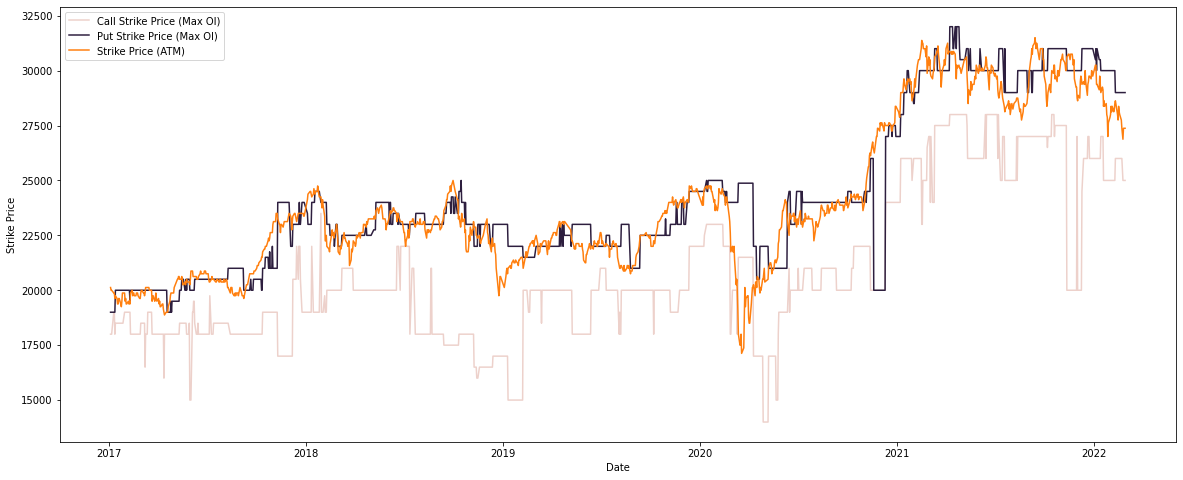

In [22]:
plt.figure(figsize = (20,8))
oFig = sns.lineplot(data = dfAtMaximumOpenInterestStrikes, x = 'Date', y =  'StrikePrice_AtMaximumOpenInterest', hue = 'Putcall', legend = False)
oFig = sns.lineplot(data = dfAtTheMoneyStrikes, x = 'Date', y =  'StrikePrice_AtTheMoney', legend =False)
oFig.set_ylabel('Strike Price')
plt.legend(labels=["Call Strike Price (Max OI)","Put Strike Price (Max OI)", 'Strike Price (ATM)'])

### Identify expected changes on strikes

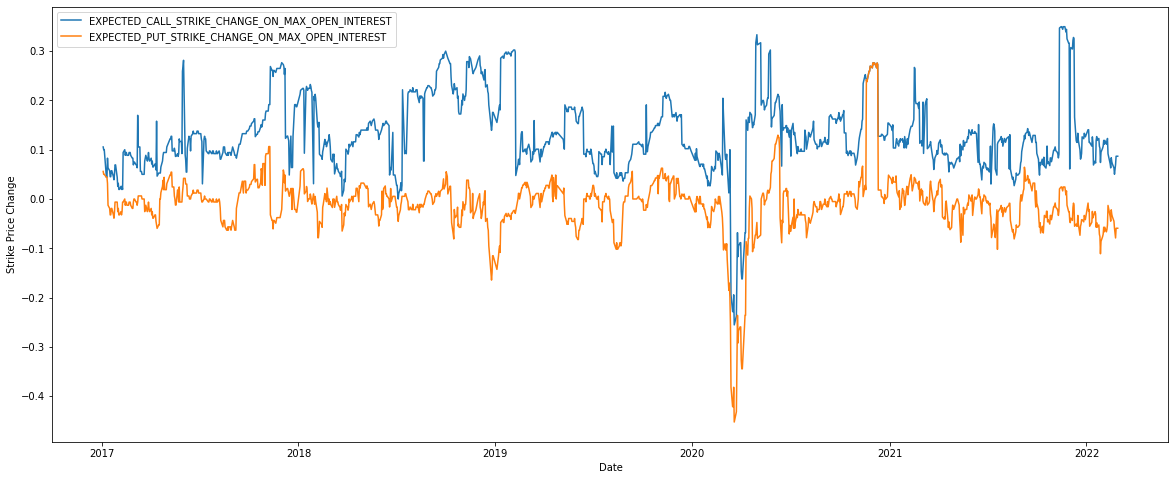

In [23]:
dfOptionsCompiled = dfAtMaximumOpenInterestStrikes.merge(right = dfAtTheMoneyStrikes, left_on = ['Date'], right_on = ['Date'])
dfOptionsCompiled['ExpectedChangeOnStrike'] = (dfOptionsCompiled['StrikePrice_AtTheMoney'] - dfOptionsCompiled['StrikePrice_AtMaximumOpenInterest']) /dfOptionsCompiled['StrikePrice_AtTheMoney']
dfOptionsCompiled = dfOptionsCompiled[['Date', 'Putcall', 'ExpectedChangeOnStrike']].pivot(index='Date', columns='Putcall', values='ExpectedChangeOnStrike')
dfOptionsCompiled.rename(columns={1: "EXPECTED_CALL_STRIKE_CHANGE_ON_MAX_OPEN_INTEREST", 
                                 2: "EXPECTED_PUT_STRIKE_CHANGE_ON_MAX_OPEN_INTEREST"}, inplace = True)

plt.figure(figsize = (20,8))
oFig = sns.lineplot(data = dfOptionsCompiled.reset_index(), x = 'Date', y =  'EXPECTED_CALL_STRIKE_CHANGE_ON_MAX_OPEN_INTEREST', legend =True)
oFig = sns.lineplot(data = dfOptionsCompiled.reset_index(), x = 'Date', y =  'EXPECTED_PUT_STRIKE_CHANGE_ON_MAX_OPEN_INTEREST', legend =True)
oFig.set_ylabel('Strike Price Change')
plt.legend(labels=["EXPECTED_CALL_STRIKE_CHANGE_ON_MAX_OPEN_INTEREST","EXPECTED_PUT_STRIKE_CHANGE_ON_MAX_OPEN_INTEREST"])

# COMPILE DATASETS

In [24]:
ixDatesToPredict = np.unique(dfStockPricesTest['Date'].unique())
ixDatesNotToPriedict = np.unique(dfStockPrices['Date'][~dfStockPrices['Date'].isin(ixDatesToPredict)].unique())

In [25]:
iSecurityToPredict = 1301

In [26]:
def aGetSameSectorSecurityCodes(p_iSecurityToPredict):
    i33SectorCode = dfStockList.loc[p_iSecurityToPredict]['33SectorCode']
    return  list(dfStockList[dfStockList['33SectorCode'] == i33SectorCode].index)

## Input Dataset

In [27]:
def dfGetInputDataset(p_iSecurityToPredict,  p_dfStockPrices, p_dfSecondaryStockPrices):
    aSameSectorSecurityCodes = aGetSameSectorSecurityCodes(p_iSecurityToPredict)
    
    dfSameSectorPrices = p_dfStockPrices[p_dfStockPrices['SecuritiesCode'].isin(aSameSectorSecurityCodes)]
    dfSameSectorPrices = dfSameSectorPrices.pivot(index = 'Date', columns = 'SecuritiesCode', values = ['RETURN'])

    dfSameSectorStockPricesTrain = p_dfSecondaryStockPrices[p_dfSecondaryStockPrices['SecuritiesCode'].isin(aSameSectorSecurityCodes)]
    dfSameSectorStockPricesTrain = dfSameSectorStockPricesTrain.pivot(index = 'Date', columns = 'SecuritiesCode', values = ['RETURN'])
    
    dfInput = dfSameSectorPrices.merge(right = dfSameSectorStockPricesTrain, left_index = True, right_index = True, how = 'outer')
    
    dfInput.columns  = dfInput.columns.map('{0[0]}|{0[1]}'.format)
    
    dfInput = dfInput.merge(right = dfOptionsCompiled, left_index = True, right_index = True, how = 'outer')
       
    dfInput.fillna(-1, inplace = True)
    return dfInput

In [28]:
dfX = dfGetInputDataset(iSecurityToPredict, dfStockPrices, dfSecondaryStockPrices)

## Output Dataset

In [29]:
def dfGetOutputDataset(p_iSecurityToPredict,  p_dfStockPrices):
    
    dfSameSectorPrices = p_dfStockPrices[p_dfStockPrices['SecuritiesCode'] == p_iSecurityToPredict]
    dfSameSectorPrices = dfSameSectorPrices.pivot(index = 'Date', columns = 'SecuritiesCode', values = ['Target'])
    
    dfOutput = dfSameSectorPrices
    
    dfOutput.columns  = dfOutput.columns.map('{0[0]}|{0[1]}'.format)
    
    dfOutput.fillna(-1, inplace = True)
    
    return dfOutput

In [30]:
dfY = dfGetOutputDataset(iSecurityToPredict, dfStockPrices)

## Train, Validation & Test Split

In [31]:
fTrainingRatio = 0.70
ixTrain, ixVal = train_test_split(
    ixDatesNotToPriedict,
    test_size=1-fTrainingRatio,
    shuffle=False)
ixTest = ixDatesToPredict

dfTrainX = dfX.loc[ixTrain]
dfValX = dfX.loc[ixVal]
dfTestX = dfX.loc[ixTest]

dfTrainY = dfY.loc[ixTrain]
dfValY = dfY.loc[ixVal]
dfTestY = dfY.loc[ixTest]

# EXPLORATORY ANALYSIS

## Correlation Analysis

<AxesSubplot:>

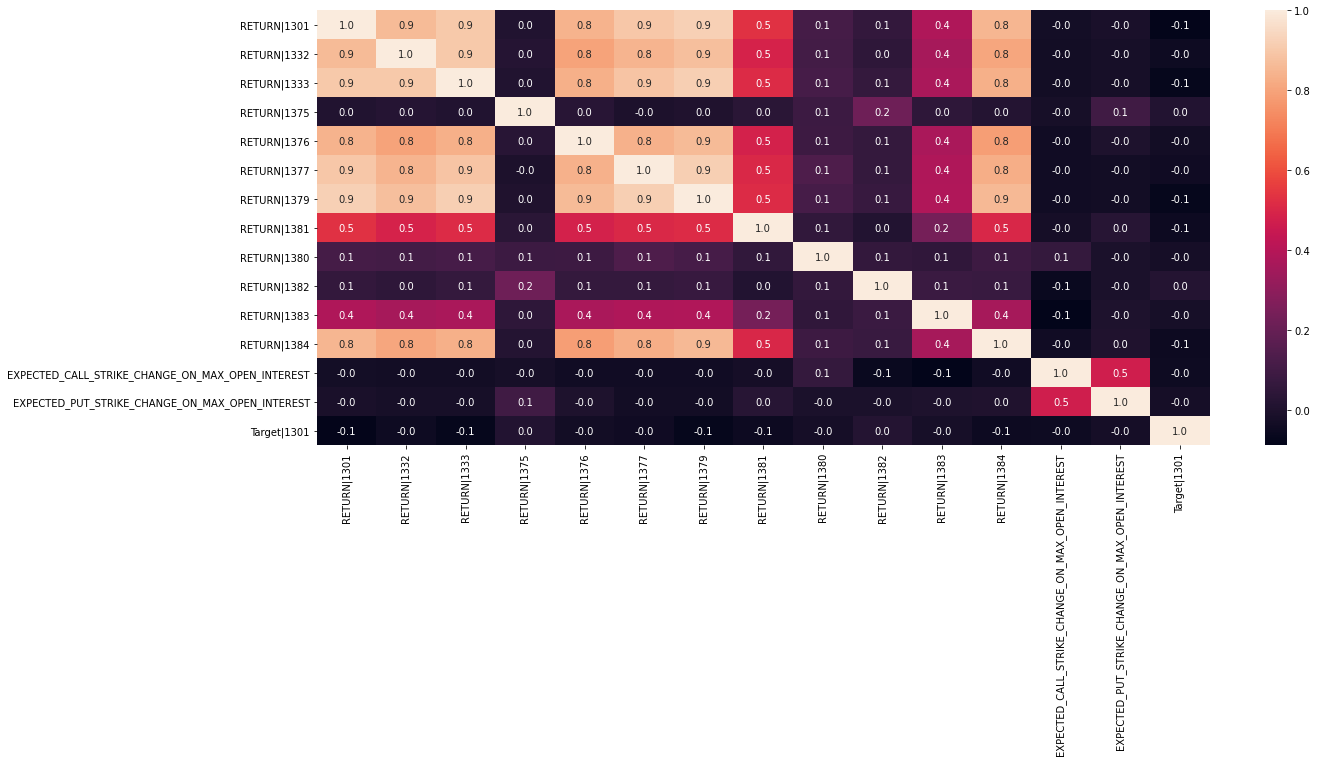

In [38]:
plt.figure(figsize = (20,8))
sns.heatmap(data = dfX.merge(dfY, left_index = True, right_index = True).corr(), annot=True, fmt='.1f')

# MODEL

## Evaluation Metric

In [ ]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

## Compile Model

In [ ]:
iNrOfInputFeatures = dfTestX.shape[1]
iNrOfOutputFeatures = dfTestY.shape[1]
iNrOfHiddenNeurons = 50

aInputMlp = keras.Input(shape = (iNrOfInputFeatures))

aW = keras.layers.Dense(iNrOfHiddenNeurons)(aInputMlp)
aW = keras.layers.Dropout(0.1)(aW)

aW = keras.layers.Dense(iNrOfOutputFeatures)(aW)

aOutputMlp = aW
oModelMlp = keras.Model(
    inputs=aInputMlp,
    outputs=aOutputMlp
)

oOptimizerMlp = tf.keras.optimizers.Adam(learning_rate=1e-04)
oModelMlp.compile(optimizer=oOptimizerMlp,
                  loss = 'mse'
                 )

oPredictiveModel = oModelMlp

tf.keras.utils.plot_model(oPredictiveModel,  show_shapes=True)

## Fit Model

In [ ]:
iEpochSize = 10000
iBatchSize = 32

oEarlyStop = EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min', 
    verbose = 0 , 
    patience = 20, 
    restore_best_weights = True)


dtStartTime = time.time()
oPredictiveModel.fit(
    dfTrainX.values, 
    dfTrainY.values, 
    epochs=iEpochSize, 
    batch_size=iBatchSize, 
    verbose=0, 
    validation_data= (dfValX.values, dfValY.values),
    validation_batch_size= iBatchSize
    ,callbacks=[oEarlyStop]
)
dtEndTime = time.time()
dtTrainingDuration = dtEndTime -dtStartTime

dfHistory = pd.DataFrame(oPredictiveModel.history.history)

In [ ]:
plt.figure(figsize = (20, 8))
sns.lineplot(data = dfHistory)

## Test Model

In [ ]:
aPredY = oPredictiveModel.predict(dfTestX)
dfPredY = pd.DataFrame(data = aPredY, index = ixTest, columns = dfTestY.columns)

## RESULTS

In [ ]:
for sCol in dfTestY.columns:
    aActual = dfTestY.loc[:, sCol].values
    aPred = dfPredY.loc[:, sCol].values
    
    print(str(sCol) + ': mae: ' + str(round(mean_absolute_error(aActual, aPred),4)))
    print(str(sCol) + ': mse: ' + str(round(mean_squared_error(aActual, aPred),4)))
    print(str(sCol) + ': r2: ' + str(round(r2_score(aActual, aPred),1)))

In [ ]:
dfComparision = dfTestY.stack().reset_index()
dfComparision.rename(columns = {'level_1':'Stock', 0:'Actual'}, inplace = True)

dfComparision['Predicted'] = dfPredY.stack().reset_index()[0].values

plt.figure(figsize = (20, 8))

oFig = sns.FacetGrid(data = dfComparision, col = 'Stock', col_wrap = 4, sharey = False, sharex = False)
oFig.map(sns.scatterplot, 'Actual', 'Predicted')